In [1]:
# IMPORTS
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from camel_tools.utils.normalize import normalize_alef_maksura_ar, normalize_alef_ar, normalize_teh_marbuta_ar
from camel_tools.utils.dediac import dediac_ar

2025-12-03 17:34:09.566705: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764783249.588196     126 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764783249.594744     126 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [2]:
train_pos = pd.read_csv('/kaggle/input/arabic-sentiment-twitter-corpus/train_Arabic_tweets_positive_20190413.tsv', sep='\t', header=None, names=['tweet'])
train_neg = pd.read_csv('/kaggle/input/arabic-sentiment-twitter-corpus/train_Arabic_tweets_negative_20190413.tsv', sep='\t', header=None, names=['tweet'])
test_pos = pd.read_csv('/kaggle/input/arabic-sentiment-twitter-corpus/test_Arabic_tweets_positive_20190413.tsv', sep='\t', header=None, names=['tweet'])
test_neg = pd.read_csv('/kaggle/input/arabic-sentiment-twitter-corpus/test_Arabic_tweets_negative_20190413.tsv', sep='\t', header=None, names=['tweet'])

train_pos['label'] = 1
train_neg['label'] = 0
test_pos['label'] = 1
test_neg['label'] = 0

df = pd.concat([train_pos, train_neg, test_pos, test_neg], ignore_index=True)
print(df['label'].value_counts())

label
1    28513
0    28282
Name: count, dtype: int64


In [3]:
# —————— 2. ADVANCED ARABIC CLEANING (THE KEY!) ——————
def clean_arabic_text(text):
    if not isinstance(text, str):
        return ""
    # Normalize Arabic letters
    text = normalize_alef_ar(text)
    text = normalize_alef_maksura_ar(text)
    text = normalize_teh_marbuta_ar(text)
    
    # Remove diacritics
    text = dediac_ar(text)
    
    # Remove emojis, mentions, hashtags content, urls
    text = re.sub(r'[@#]\w+', ' ', text)
    text = re.sub(r'http\S+', ' ', text)
    text = re.sub(r'[^\u0600-\u06FF\u0750-\u077F\u08A0-\u08FF\s]', ' ', text)  # Keep Arabic only
    
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Remove repeated letters more than 2 (like هههههه → هه)
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)
    
    return text

print("Cleaning text...")
df['clean_text'] = df['tweet'].apply(clean_arabic_text)

# Remove empty tweets
df = df[df['clean_text'].str.len() > 5].reset_index(drop=True)
print("Final shape:", df.shape)

Cleaning text...
Final shape: (56499, 3)


In [4]:
# —————— 3. TOKENIZATION & PADDING ——————
MAX_WORDS = 25000
MAX_LEN = 80

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(df['clean_text'])

sequences = tokenizer.texts_to_sequences(df['clean_text'])
padded = pad_sequences(sequences, maxlen=MAX_LEN, padding='post', truncating='post')

X = padded
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Train: (45199, 80), Test: (11300, 80)


In [5]:
# —————— 4. BUILD BIDIRECTIONAL LSTM MODEL (WORKING ONE!) ——————
model = Sequential([
    Embedding(input_dim=MAX_WORDS, output_dim=128, input_length=MAX_LEN),
    Bidirectional(LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1764783353.586556     126 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [6]:
# —————— 5. TRAIN WITH EARLY STOPPING ——————
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7)
]

history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
707/707 ━━━━━━━━━━━━━━━━━━━━ 227s 306ms/step - accuracy: 0.6272 - loss: 0.6125 - val_accuracy: 0.7749 - val_loss: 0.4401 - learning_rate: 0.0010
Epoch 2/30
707/707 ━━━━━━━━━━━━━━━━━━━━ 213s 301ms/step - accuracy: 0.8332 - loss: 0.3564 - val_accuracy: 0.7848 - val_loss: 0.4270 - learning_rate: 0.0010
Epoch 3/30
707/707 ━━━━━━━━━━━━━━━━━━━━ 213s 301ms/step - accuracy: 0.8831 - loss: 0.2623 - val_accuracy: 0.7842 - val_loss: 0.4889 - learning_rate: 0.0010
Epoch 4/30
707/707 ━━━━━━━━━━━━━━━━━━━━ 215s 304ms/step - accuracy: 0.9083 - loss: 0.2018 - val_accuracy: 0.7855 - val_loss: 0.6769 - learning_rate: 0.0010
Epoch 5/30
707/707 ━━━━━━━━━━━━━━━━━━━━ 216s 306ms/step - accuracy: 0.9309 - loss: 0.1477 - val_accuracy: 0.7813 - val_loss: 0.8234 - learning_rate: 5.0000e-04
Epoch 6/30
707/707 ━━━━━━━━━━━━━━━━━━━━ 214s 302ms/step - accuracy: 0.9415 - loss: 0.1237 - val_accuracy: 0.7828 - val_loss: 1.0905 - learning_rate: 5.0000e-04
Epoch 7/30
707/707 ━━━━━━━━━━━━━━━━━━━━ 212s 300ms/step 

354/354 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step
FINAL ACCURACY: 0.7854867256637168

Classification Report:
              precision    recall  f1-score   support

    Negative       0.78      0.80      0.79      5623
    Positive       0.79      0.77      0.78      5677

    accuracy                           0.79     11300
   macro avg       0.79      0.79      0.79     11300
weighted avg       0.79      0.79      0.79     11300



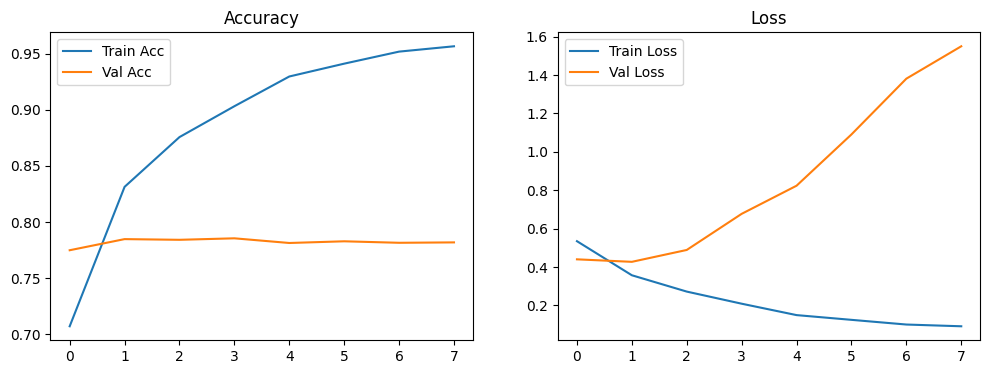

In [8]:
# —————— 6. EVALUATE ——————
from sklearn.metrics import accuracy_score

y_pred = (model.predict(X_test) > 0.5).astype(int)

print("FINAL ACCURACY:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

# Plot
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()